<a href="https://colab.research.google.com/github/MarcosVel/Deep-Learning/blob/master/LSTM_Stock_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
print(tf.__version__)

2023-05-25 00:15:40.400246: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 00:15:40.430129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 00:15:40.868171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX
...,...,...,...,...,...,...,...
1254,2018-02-01,56.280,56.420,55.890,56.000,14690146,SBUX
1255,2018-02-02,55.900,56.320,55.700,55.770,15358909,SBUX
1256,2018-02-05,55.530,56.260,54.570,54.690,16059955,SBUX
1257,2018-02-06,53.685,56.060,53.560,55.610,17415065,SBUX


In [ ]:
df.describe()

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,48.344296,48.717212,47.956827,48.352246,9.230517e+06
std,10.389108,10.458485,10.304082,10.391867,4.382209e+06
min,26.535000,26.820000,26.260000,26.605000,2.215418e+06
25%,38.372500,38.690650,38.087750,38.355000,6.661026e+06
50%,53.520000,53.995000,53.180000,53.540000,8.138313e+06
75%,57.270000,57.735000,56.850000,57.360000,1.059388e+07
max,64.850000,64.870000,64.180000,64.570000,5.345479e+07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 69.0+ KB


In [ ]:
# how can I use LSTM to predict the closing price?
# we'll use the last 10 days' prices to predict the next day
# so it's a many to one sequence prediction
# we need to scale the data

series = df['close'].values.reshape(-1, 1)
series

array([[28.185],
       [28.07 ],
       [28.13 ],
       ...,
       [54.69 ],
       [55.61 ],
       [54.46 ]])

In [ ]:
# normalize the dataset

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2]) # fit scaler to first half of series
series = scaler.transform(series).flatten() # scale the whole series now
series

array([-1.62500489, -1.64174953, -1.6330132 , ...,  2.2342704 ,
        2.36822751,  2.20078112])

In [ ]:
# build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [ ]:
# try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.1),
)

2023-05-25 00:15:42.148250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 00:15:42.164970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 00:15:42.165099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80


2023-05-25 00:15:42.990339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 00:15:42.991154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 00:15:42.991799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/20 [>.............................] - ETA: 43s - loss: 0.8917

2023-05-25 00:15:45.032806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 3s 13ms/step - loss: 0.1155 - val_loss: 0.1496
Epoch 2/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0134 - val_loss: 0.0793
Epoch 3/80
 1/20 [>.............................] - ETA: 0s - loss: 0.0234

2023-05-25 00:15:45.312258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 00:15:45.313021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 00:15:45.313597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0307
Epoch 4/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0964
Epoch 5/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0274
Epoch 6/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0320
Epoch 7/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0394
Epoch 8/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0375
Epoch 9/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0460
Epoch 10/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0397
Epoch 11/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0492
Epoch 12/80
20/20 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0428
Epoch 13/80
20/20 [=========

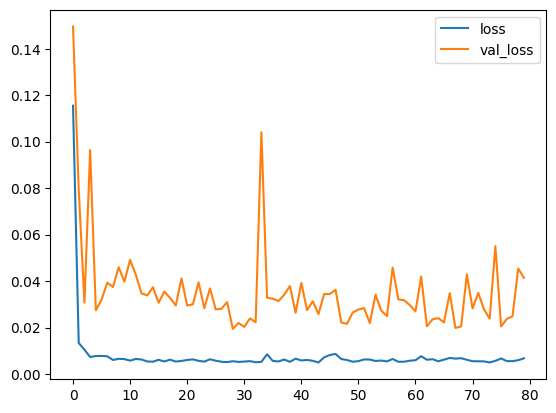

In [ ]:
# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

40/40 [==============================] - 0s 783us/step


2023-05-25 00:15:50.204309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 00:15:50.205160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 00:15:50.205770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(1249, 1)


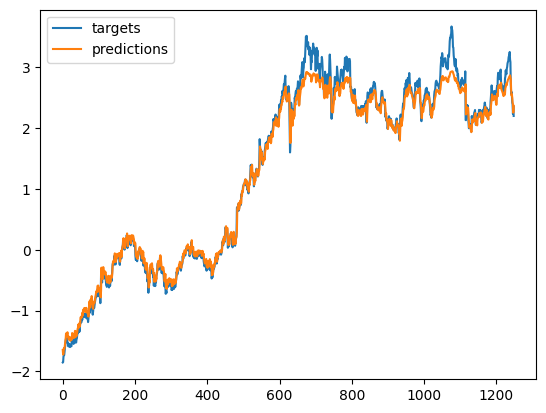

In [ ]:
# one step forecast using true targets
# Note: even the one-step forecast fails
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 11ms/step


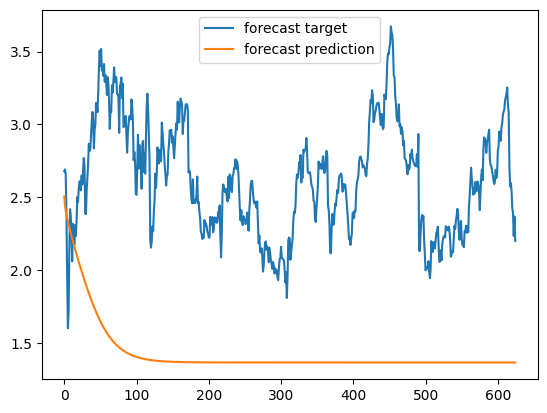

In [ ]:
# multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()